今回は「LSTM-Based ECG Classification for Continuous Monitoring on Personal Wearable Devices」の論文の再現実装を行う。
ウェアラブルで心電図を常時計測する場合、リソース制約（低電力・低メモリ・CPU弱い）でも動くアルゴリズムが必要である。手法としては

①ECG信号をWavelet変換で特徴抽出（周波数・時間両方の情報を保持）

②軽量な**LSTM（長短期記憶ネットワーク）**を使って、連続的な心拍分類を行う

その結果精度は高いが、計算コストを抑えてリアルタイム動作に耐えると論文上では示されている。
また、モバイルやRaspberry Piなど低スペック端末に移植しやすいそうだ。実際に検証してみよう。

論文は以下のリンクから見ることができる。
https://medium.com/%40protobioengineering/how-to-get-heart-data-from-the-mit-bih-arrhythmia-database-e452d4bf7215

**データセット取得：MIT-BIH Arrhythmia Database**

MIT‑BIH Arrhythmia Database はPhysioNetにて公開されており、世界中の研究で標準的に使われています


In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


実験

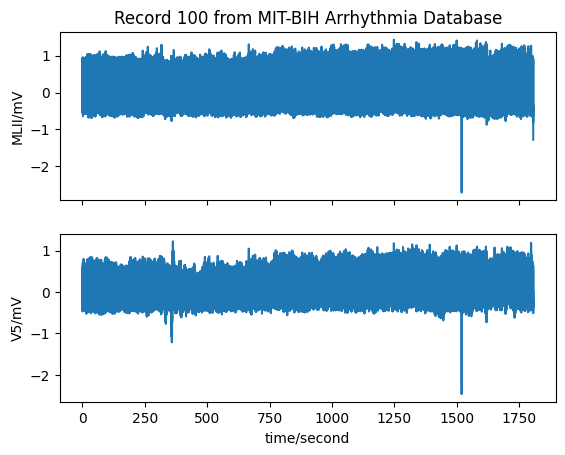

In [2]:
import wfdb

# PhysioNet から '100' レコードを取得してプロット
record = wfdb.rdrecord('100', pn_dir='mitdb')
wfdb.plot_wfdb(record=record, title='Record 100 from MIT-BIH Arrhythmia Database')


論文最小構成例

In [3]:
# 必要ライブラリ
!pip install wfdb pywavelets torch torchvision

import wfdb
import numpy as np
import pywt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [4]:
# -----------------------
# 1. データロード（MIT-BIHから直接取得）
# -----------------------
record = wfdb.rdrecord('100', pn_dir='mitdb')   # 100番の記録を取得
signal = record.p_signal[:,0]  # 1ch目のECG信号

In [5]:
# -----------------------
# 2. 前処理（Wavelet変換で特徴抽出）
# -----------------------
def preprocess_signal(sig, length=256):
    # 長さを統一
    if len(sig) < length:
        sig = np.pad(sig, (0, length-len(sig)))
    else:
        sig = sig[:length]
    # Wavelet変換
    coeffs = pywt.wavedec(sig, 'db4', level=4)
    feat = np.concatenate(coeffs)
    return feat[:length]  # LSTM入力長に揃える

X = []
y = []
for i in range(0, len(signal)-256, 256):   # 簡易的に256サンプルごとに切り出し
    feat = preprocess_signal(signal[i:i+256])
    X.append(feat)
    y.append(0)  # 本来はアノテーション（正常/異常）を使う

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)


In [6]:
# -----------------------
# 3. PyTorch Dataset定義
# -----------------------
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(-1)  # (N, L, 1)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ECGDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
# -----------------------
# 4. LSTMモデル定義
# -----------------------
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=2):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]   # 最後の時刻の隠れ状態
        out = self.fc(out)
        return out

model = ECG_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
# -----------------------
# 5. 学習ループ
# -----------------------
for epoch in range(3):  # 本格的には20epoch程度回す
    for X_batch, y_batch in loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("✅ 学習完了（デモ版）")

Epoch 1, Loss: 0.0012
Epoch 2, Loss: 0.0005
Epoch 3, Loss: 0.0003
✅ 学習完了（デモ版）


論文実際の実装

In [10]:
# ライブラリ準備
!pip install wfdb pywavelets torch torchvision scikit-learn

import wfdb
import numpy as np
import pywt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# -----------------------
# 1. データ取得 (MIT-BIH, Record 100 を例)
# -----------------------
record = wfdb.rdrecord('100', pn_dir='mitdb')
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')

signal = record.p_signal[:,0]   # 1ch目のECG
ann_samples = annotation.sample
ann_symbols = annotation.symbol

print("アノテーションの一部:", ann_samples[:10], ann_symbols[:10])

アノテーションの一部: [  18   77  370  662  946 1231 1515 1809 2044 2402] ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']


In [17]:
# -----------------------
# 2. ラベル付け (正常 vs 異常の2クラス)
# -----------------------
# N: Normal, V: Premature Ventricular Contraction (異常例)
normal_symbols = ['N']
abnormal_symbols = ['V', 'A', 'L', 'R']  # 代表的な不整脈
segments = []
labels = []

window_size = 256
for idx, pos in enumerate(ann_samples):
    if pos+window_size < len(signal):
        symbol = ann_symbols[idx]

        # ラベルを決定
        if symbol in normal_symbols:
            label = 0
        elif symbol in abnormal_symbols:
            label = 1
        else:
            continue  # ← 無効なら完全にスキップ

        # セグメントを切り出す
        segment = signal[pos:pos+window_size]
        coeffs = pywt.wavedec(segment, 'db4', level=4)
        feat = np.concatenate(coeffs)[:window_size]

        # ラベルとセットで追加
        segments.append(feat)
        labels.append(label)

# numpy配列に変換
X = np.array(segments, dtype=np.float32)
y = np.array(labels, dtype=np.int64)

print("X shape:", X.shape, " y length:", len(y))
assert len(X) == len(y), "❌ Xとyの長さが一致していません！"


X shape: (2272, 256)  y length: 2272


In [20]:
# -----------------------
# 3. PyTorch Dataset
# -----------------------
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(-1)  # (N, L, 1)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ECGDataset(X, y)
assert len(X) == len(y)

# train/test 分割
n_samples = len(X)   # 2272
train_size = int(0.8 * n_samples)
test_size = n_samples - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------
# 4. LSTMモデル定義
# -----------------------
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=2):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

model = ECG_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
print("len(X):", len(X))
print("len(y):", len(y))
print("dataset長さ:", len(dataset))


len(X): 2272
len(y): 2272
dataset長さ: 2272


In [23]:
# -----------------------
# 5. 学習ループ
# -----------------------
for epoch in range(50):  # 本番は20-50 epoch程度
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.0767
Epoch 2, Loss: 0.0751
Epoch 3, Loss: 0.0762
Epoch 4, Loss: 0.0752
Epoch 5, Loss: 0.0759
Epoch 6, Loss: 0.0756
Epoch 7, Loss: 0.0757
Epoch 8, Loss: 0.0762
Epoch 9, Loss: 0.0749
Epoch 10, Loss: 0.0756
Epoch 11, Loss: 0.0750
Epoch 12, Loss: 0.0767
Epoch 13, Loss: 0.0752
Epoch 14, Loss: 0.0764
Epoch 15, Loss: 0.0755
Epoch 16, Loss: 0.0761
Epoch 17, Loss: 0.0754
Epoch 18, Loss: 0.0753
Epoch 19, Loss: 0.0753
Epoch 20, Loss: 0.0759
Epoch 21, Loss: 0.0752
Epoch 22, Loss: 0.0751
Epoch 23, Loss: 0.0768
Epoch 24, Loss: 0.0751
Epoch 25, Loss: 0.0762
Epoch 26, Loss: 0.0757
Epoch 27, Loss: 0.0755
Epoch 28, Loss: 0.0754
Epoch 29, Loss: 0.0767
Epoch 30, Loss: 0.0751
Epoch 31, Loss: 0.0750
Epoch 32, Loss: 0.0763
Epoch 33, Loss: 0.0754
Epoch 34, Loss: 0.0752
Epoch 35, Loss: 0.0754
Epoch 36, Loss: 0.0751
Epoch 37, Loss: 0.0757
Epoch 38, Loss: 0.0751
Epoch 39, Loss: 0.0751
Epoch 40, Loss: 0.0758
Epoch 41, Loss: 0.0756
Epoch 42, Loss: 0.0758
Epoch 43, Loss: 0.0758
Epoch 44, Loss: 0.07


Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       447
    Abnormal       0.00      0.00      0.00         8

    accuracy                           0.98       455
   macro avg       0.49      0.50      0.50       455
weighted avg       0.97      0.98      0.97       455



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


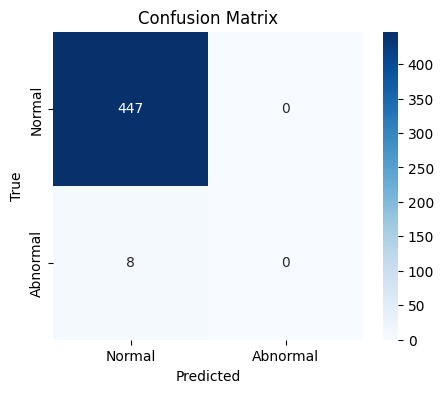

In [24]:
# -----------------------
# 6. 評価
# -----------------------
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"]))

# 混同行列可視化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()